In [1]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from time import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [2]:

# Let's first load the data and take a look at what we have.
df = pd.read_csv('heathrow_final.csv')

In [3]:
df=df.dropna()

In [4]:
df.drop(['Date'], 
               axis=1,
              inplace=True)


In [5]:
df

,Nox_tropo,Nox_ground,tavg,tmin,tmax,prcp,wdir,wspd,pres,Hum,NO,NO2,PM10
0,232.12,59.75,18.7,15.5,22.6,0.0,2,12.5,1023.9,58.67,21.35,27.00,12.395833
1,168.04,73.87,18.6,13.9,23.4,0.0,1,10.1,1021.8,65.83,25.76,34.37,14.937500
2,194.00,59.39,19.2,13.7,24.4,0.0,2,8.4,1021.5,65.33,15.23,36.05,20.891667
3,343.27,68.19,20.6,15.7,26.8,0.0,2,10.1,1021.8,65.00,16.71,42.57,22.316667
4,190.16,78.65,21.8,14.9,27.8,0.0,3,10.2,1020.0,59.58,26.03,38.74,17.279167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,85.24,40.98,3.2,0.1,5.6,0.5,2,11.3,1019.5,84.79,10.20,25.35,7.420833
576,163.94,37.20,-0.1,-1.7,2.1,0.0,4,10.6,1018.6,91.63,6.15,27.77,15.304167
577,282.06,58.82,0.1,-2.1,2.6,0.0,3,6.6,1026.4,94.25,17.17,32.50,13.537500
578,147.20,37.50,4.8,-0.8,8.3,0.5,3,14.8,1020.0,86.63,8.21,25.78,6.412500


In [6]:
X = df.drop(['Nox_tropo'], axis=1).values
y = df['Nox_tropo'].values

In [7]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [8]:

 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
dataset = df
values = dataset.values

In [14]:

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_hours = 1
n_features = 13
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours , 2)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,14,15,16,17,18,19,20,21,22,23,24,24,25,26]], axis=1, inplace=True)
# print(reframed.head())

In [15]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var1(t)'],
      dtype='object')

In [16]:

# split into train and test sets
values = reframed.values

# split into train and test sets
values = reframed.values

#80% training data
n_train_hours = 460
train = values[:n_train_hours]
test = values[n_train_hours:]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# train = data.values[:459]
# test = data.values[459:]

# # Separate input and output
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]

# # Reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# # Print all shapes
# train_X.shape, train_y.shape, test_X.shape, test_y.shape

(460, 13) 460 (460,)
(460, 1, 13) (460,) (115, 1, 13) (115,)


In [17]:
train_y

array([0.14313806, 0.18170149, 0.14215485, 0.16618872, 0.19475625,
       0.13737539, 0.1449406 , 0.10468387, 0.10990031, 0.1327598 ,
       0.2962174 , 0.24296054, 0.13729346, 0.3498293 , 0.3001229 ,
       0.20092858, 0.20464291, 0.22698348, 0.16657108, 0.19117848,
       0.14808139, 0.2341117 , 0.07936638, 0.29602622, 0.22714734,
       0.20849379, 0.25874642, 0.10301789, 0.108644  , 0.17866994,
       0.201229  , 0.15515499, 0.18735491, 0.16733579, 0.17017616,
       0.2211935 , 0.21627748, 0.12265465, 0.1517684 , 0.19554827,
       0.26210569, 0.12503073, 0.20546224, 0.16231053, 0.30725113,
       0.27783695, 0.35821385, 0.27393145, 0.39912604, 0.17858801,
       0.22335109, 0.17823296, 0.27368565, 0.17869726, 0.16501434,
       0.18940325, 0.34297419, 0.19309026, 0.16741772, 0.22698348,
       0.1809914 , 0.18153762, 0.20294961, 0.14488598, 0.18915745,
       0.45647958, 0.58989485, 0.37072238, 0.42138468, 0.3415267 ,
       0.50293596, 0.16476854, 0.20297692, 0.10301789, 0.33497

In [ ]:
train_X.shape[0], train_X.shape[2]

Epoch 1/50
154/154 - 3s - loss: 0.0146 - val_loss: 0.0270
Epoch 2/50
154/154 - 0s - loss: 0.0062 - val_loss: 0.0083
Epoch 3/50
154/154 - 0s - loss: 0.0018 - val_loss: 0.0041
Epoch 4/50
154/154 - 0s - loss: 0.0012 - val_loss: 0.0028
Epoch 5/50
154/154 - 0s - loss: 8.8435e-04 - val_loss: 0.0023
Epoch 6/50
154/154 - 0s - loss: 7.2948e-04 - val_loss: 0.0019
Epoch 7/50
154/154 - 0s - loss: 5.8782e-04 - val_loss: 0.0016
Epoch 8/50
154/154 - 1s - loss: 4.9040e-04 - val_loss: 0.0013
Epoch 9/50
154/154 - 0s - loss: 4.1302e-04 - val_loss: 0.0012
Epoch 10/50
154/154 - 0s - loss: 3.5986e-04 - val_loss: 0.0011
Epoch 11/50
154/154 - 0s - loss: 3.2157e-04 - val_loss: 0.0011
Epoch 12/50
154/154 - 0s - loss: 2.8872e-04 - val_loss: 9.8857e-04
Epoch 13/50
154/154 - 0s - loss: 2.7002e-04 - val_loss: 9.4161e-04
Epoch 14/50
154/154 - 0s - loss: 2.5286e-04 - val_loss: 8.8238e-04
Epoch 15/50
154/154 - 0s - loss: 2.3644e-04 - val_loss: 8.1229e-04
Epoch 16/50
154/154 - 0s - loss: 2.2423e-04 - val_loss: 7.7412e-

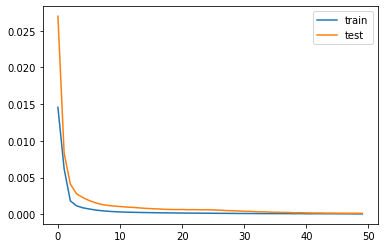

In [18]:


model = Sequential()
model.add(LSTM(13, input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu'))
model.add(Dense(38, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=3, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
import math
from math import sqrt

In [20]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -12:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -12:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.453


In [21]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(inv_y,inv_yhat)

5.387156644438312

In [22]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mean_absolute_percentage_error(inv_y,inv_yhat)

30.783642046063335

<!-- 61-1 Test RMSE: Test RMSE: 63.163

13-40-1 Test RMSE: 67.366

13-100-1 Test RMSE: 65.965

13- -->